<a href="https://colab.research.google.com/github/wFairmanOlin/Biomass/blob/master/TF_lite_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install --upgrade pip

In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import pandas as pd
from datetime import datetime
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Import from Firebase

To download data from firebase, you must have a unique key stored locally. The key will not be available from github and should not be uploaded to github. The following code currently downloads all the data from Firebase, as our database grows, future versions should look into only downloading the latest data

In [ ]:
### ONLY RUN ONCE! ###
#download data from firebase
cred = credentials.Certificate("/content/haucs-monitoring-firebase-adminsdk-wt1pb-1291f2083e.json")
firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

In [ ]:
## ONLY RUN TO REFRESH DATA! ###
ref = db.reference('/')
data = ref.get()

### RUN TO SAVE JSON FILE LOCALLY ###
with open('latest_data.json', 'w') as f:
    json.dump(data, f)

# Date Time
Firebase stores the time of data entries as a local datetime string. Due to daylight savings issues, we have to be careful with how to process datetime objects. The following code block handles converting local datetime objects into timezone aware datetime objects.

For data analysis, the date time objects should probably be converted into timestamps.

In [ ]:
def to_datetime(dates, tz_aware=True):
    dt = []
    for i in dates:
        if "T" in i or "-" in i:
          i = i.replace("T","_")
          i = i.replace("-","")
        i_dt = datetime.strptime(i, "%Y%m%d_%H:%M:%S")
        # i_dt = datetime.fromisoformat(date)
        
        if tz_aware:
            tz = pytz.timezone('US/Eastern')
            i_dt = tz.localize(i_dt)

        dt.append(i_dt)
    return dt

#time
example = datetime.fromisoformat("2023-03-12T01:30:05")
#time zone aware current time
# example_aware = to_datetime([str(example)])[0]

print("unaware time: ", example)
# print("aware time: ", example_aware)

print("unaware timestamp", example.timestamp())
# print("aware timestamp", example_aware.timestamp())

unaware time:  2023-03-12 01:30:05
unaware timestamp 1678584605.0


# Local Data
Harvest results and sensor anomalies are recorded locally. The sensor log file keeps track of any anomalies that occur with the sensor.
<table>
<tr> <th>Event</th>	<th>Description</th>	<th>Value</th></tr>
<tr> <td>i</td>	<td>installed in a tank</td>	<td>tank installed in</td></tr>
<tr> <td>r</td>	<td>removed from a tank</td>	<td>tank removed from</td></tr>
<tr> <td>c</td>	<td>debris cleaned from sensor</td>	<td>N/A</td></tr>
<tr> <td>f</td>	<td>sensor failure leading to missing data</td>	<td>N/A</td></tr>
</table>

In [ ]:
## information regarding sensor installments/removals
## ID - biomass sensor (not algae tank)
df_anomaly = pd.read_csv('sensor_log.csv')
df_anomaly['datetime'] = to_datetime(df_anomaly.Date)

## information regarding algae harvests
## Before - algae (kg) in tank before harvest
## After  - algae (kg) in tank after harvest
## ID - algae tank
df_harvest = pd.read_csv('harvest_log.csv')
df_harvest['datetime'] = to_datetime(df_harvest.Date)
print(df_anomaly.head())
print("\n", df_harvest.head())

                  Date  ID Event  Value                  datetime
0  2023-04-11T09:00:00   1     r    1.0 2023-04-11 09:00:00-04:00
1  2023-04-11T13:30:00   1     i    2.0 2023-04-11 13:30:00-04:00
2  2023-04-12T17:30:00   3     f    NaN 2023-04-12 17:30:00-04:00
3  2023-04-13T10:00:00   2     r    1.0 2023-04-13 10:00:00-04:00
4  2023-04-13T18:00:00   2     i    2.0 2023-04-13 18:00:00-04:00

                   Date  ID  Before  After                  datetime
0  2023-02-03T12:00:00   3   39.71  22.11 2023-02-03 12:00:00-05:00
1  2023-02-09T12:00:00   3   36.90  22.11 2023-02-09 12:00:00-05:00
2  2023-02-16T12:00:00   3   46.30  22.11 2023-02-16 12:00:00-05:00
3  2023-02-22T12:00:00   3   43.01  22.11 2023-02-22 12:00:00-05:00
4  2023-03-02T12:00:00   3   44.40  22.11 2023-03-02 12:00:00-05:00


# Processing Sensor Data

In [ ]:
def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')

class bmass_sensor():

    def __init__(self, name, data):
        self.d_dt = to_datetime(data[name]['data'])
        self.s_dt = to_datetime(data[name]['status'])
        self.on = np.array([int(data[name]['data'][i][1]) for i in data[name]['data']])
        self.off = np.array([int(data[name]['data'][i][0]) for i in data[name]['data']])
        self.g = np.array([int(data[name]['data'][i][2]) for i in data[name]['data']])
        self.battv = np.array([float(data[name]['status'][i]['batt_v']) for i in data[name]['status']])


bm1 = bmass_sensor('bmass_1', data)
bm2 = bmass_sensor('bmass_2', data)
bm3 = bmass_sensor('bmass_3', data)
bm4 = bmass_sensor('bmass_4', data)
bm5 = bmass_sensor('bmass_5', data)

In [ ]:
# print("bm1: ", bm1.d_dt[-1], " ", bm1.on[-1], " ", bm1.off[-1], " ", bm1.g[-1])
# print("bm2: ", bm2.d_dt[-1], " ", bm2.on[-1], " ", bm2.off[-1], " ", bm2.g[-1])
# print("bm3: ", bm3.s_dt[-1], " ", bm3.on[-1], " ", bm3.off[-1], " ", bm3.g[-1])
# print("bm4: ", bm4.d_dt[-1], " ", bm4.on[-1], " ", bm4.off[-1], " ", bm4.g[-1])
# print("bm5: ", bm5.d_dt[-1], " ", bm5.on[-1], " ", bm5.off[-1], " ", bm5.g[-1])

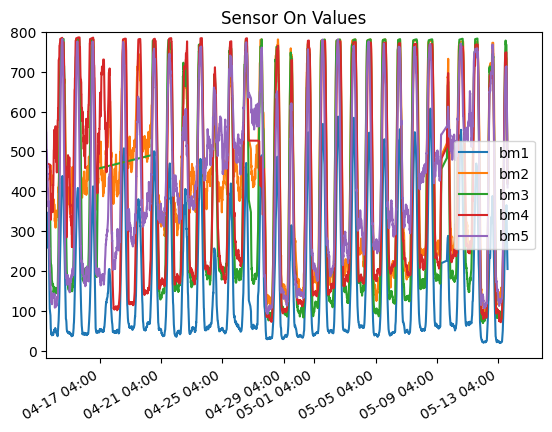

In [ ]:
# checking laser on values for all sensors
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)


lower = datetime(2023, 4, 13, hour=16)
#plot
plt.figure()
plt.plot(bm1.d_dt, moving_average(bm1.on, 20))
plt.plot(bm2.d_dt, moving_average(bm2.on, 20))
plt.plot(bm3.d_dt, moving_average(bm3.on, 20))
plt.plot(bm4.d_dt, moving_average(bm4.on, 20))
plt.plot(bm5.d_dt, moving_average(bm5.on, 20))
plt.xlim(left=lower)
plt.ylim(top=800)
plt.title("Sensor On Values")
plt.legend(['bm1','bm2', 'bm3', 'bm4', 'bm5'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

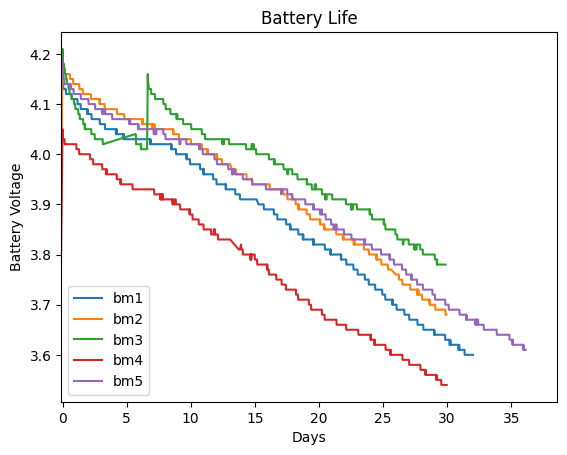

In [ ]:
# checking battery life
bm1_t = mdates.date2num(bm1.s_dt)
bm2_t = mdates.date2num(bm2.s_dt)
bm3_t = mdates.date2num(bm3.s_dt)
bm4_t = mdates.date2num(bm4.s_dt)
bm5_t = mdates.date2num(bm5.s_dt)

bm1_start = bm1_t[1633]
bm2_start = bm2_t[812]
bm3_start = bm3_t[723]
bm4_start = bm4_t[755]
bm5_start = bm5_t[0]


bm1_t = bm1_t - bm1_start
bm2_t = bm2_t - bm2_start
bm3_t = bm3_t - bm3_start
bm4_t = bm4_t - bm4_start
bm5_t = bm5_t - bm5_start

t = np.arange(1, len(bm2.battv) + 1) / 6 / 24
plt.figure()
plt.plot(bm1_t, bm1.battv)
plt.plot(bm2_t, bm2.battv)
plt.plot(bm3_t, bm3.battv)
plt.plot(bm4_t, bm4.battv)
plt.plot(bm5_t, bm5.battv)
plt.xlim(left=-.1)
plt.title("Battery Life")
plt.ylabel("Battery Voltage")
plt.xlabel("Days")
plt.legend(["bm1", "bm2", "bm3", "bm4", "bm5"], loc='lower left')
plt.show()

In [ ]:
# id = 1
# bmx = bm1
# lower = datetime(2023, 4, 10, hour=12)
# #plot
# plt.figure()
# plt.plot(bmx.d_dt, bmx.off)
# plt.plot(bmx.d_dt, bmx.on)
# plt.xlim(left=lower)
# # plt.ylim(top=400)
# plt.title("Biomass " + str(id))
# plt.legend(['off', 'on'])
# plt.gcf().autofmt_xdate()
# plt.gca().xaxis.set_major_formatter(date_formatter)

# #plot anomalies 
# bmx_anomalies = df_anomaly.index[df_anomaly.ID == id]
# print(bmx_anomalies)
# for i in bmx_anomalies:
#     print(df_anomaly.Event[i])
#     text = str(df_anomaly.Event[i])
#     pos = df_anomaly.datetime[i]
#     plt.text(pos, 500, text,
#                 bbox=dict(boxstyle="round,pad=0.3", ec='none', fc='lightblue'))
# plt.show()

#Deleting Data from Firebase
WARNING: this action will permanently alter the data in Firebase.

In [ ]:
# #select sensor and data or status path
# del_path = '/bmass_5/data'
# del_node = db.reference(del_path)
# #select start date for delete 
# del_start = datetime(2023, 4, 13, hour=10, minute=0)
# #select end date for delete
# del_end = datetime(2023, 4, 13, hour=18, minute=0)

# del_data = del_node.get()
# del_data_dt = []
# print("Deleting the Following Nodes: ", del_path)
# for i in del_data:
#     i_dt = datetime.fromisoformat(i)
#     if (del_start <= i_dt <= del_end):
#         print(i)
#         del_data_dt.append(i)
        
# #uncomment the following section to delete
# print("Should these nodes be deleted? (y/n)")
# # if (input('permanently delete (y/n): ') == 'y'):
# #     for i in del_data_dt:
# #         del_point = del_path + '/' + i
# #         del_point = db.reference(del_point)
# #         del_point.delete()

# Prediction Models 


<h3><i> Preprocessing Data

In [ ]:
# pip install scalecast --upgrade

<h5> USING GOLAY VALUES FOR PREDICTION

In [ ]:
dates = pd.to_datetime(bm1.d_dt)[:-40]
values = moving_average(bm1.g,40)[:-40]
df = pd.DataFrame({'ds': dates, 'y': values})

In [ ]:
# start_time = '23:00:00'
# end_time = '04:00:00'

# convert the 'ds' column to datetime type
# df['ds'] = pd.to_datetime(df['ds'])
# df = df.set_index('ds')
# # filter the data between 11pm and 4am
# filtered_data = df.set_index('ds').between_time(start_time, end_time)

# # display the filtered data
# print(filtered_data)

In [ ]:
print(f'Is there any Null values in the dataset : {df.isna().values.any()}')

Is there any Null values in the dataset : False


<h5> Using data only after 11th April without filtering Night-time 

In [ ]:
start_date = "2023-04-13"
mask = (df['ds'] > start_date)
df_clean = df.loc[mask]

In [ ]:
df_clean

,ds,y
1785,2023-04-13 00:20:11-04:00,1153.850
1786,2023-04-13 00:31:19-04:00,1147.575
1787,2023-04-13 00:42:42-04:00,1157.075
1788,2023-04-13 00:53:50-04:00,1158.050
1789,2023-04-13 01:04:58-04:00,1156.275
...,...,...
5578,2023-05-13 06:10:31-04:00,836.325
5579,2023-05-13 06:21:39-04:00,844.550
5580,2023-05-13 06:32:47-04:00,850.600
5581,2023-05-13 06:43:55-04:00,862.225


In [ ]:
# convert the 'ds' column to datetime type
df_clean['ds'] = pd.to_datetime(df_clean['ds'])
df_clean = df_clean.set_index('ds')

<ipython-input-18-9f50620fadf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ds'] = pd.to_datetime(df_clean['ds'])


In [ ]:
df_clean.describe()

,y
count,3798.000000
mean,1532.716548
std,328.286388
min,728.850000
25%,1347.625000
50%,1541.687500
75%,1731.612500
max,2622.275000


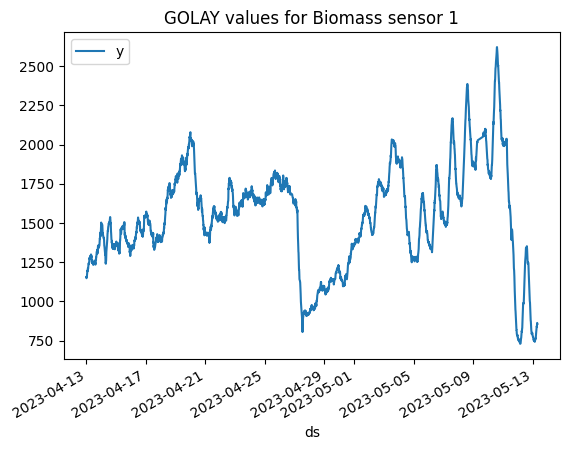

In [ ]:
df_clean.plot()
plt.title("GOLAY values for Biomass sensor 1")
plt.show()

<h5> Splitting the data 70%,10%,10% for train, test and val

In [ ]:
column_indices = {name: i for i, name in enumerate(df_clean.columns)}

n = len(df_clean)
train_df = df_clean[0:int(n*0.7)]
val_df = df_clean[int(n*0.7):int(n*0.9)]
test_df = df_clean[int(n*0.9):]

num_features = df_clean.shape[1]

<h5> Normalizing the data

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/train_std
test_df = (test_df - train_mean)/train_std
val_df = (val_df - train_mean)/train_std

In [ ]:
train_df.describe()

,y
count,2.658000e+03
mean,-2.031650e-16
std,1.000000e+00
min,-2.658779e+00
25%,-5.639925e-01
50%,8.504896e-02
75%,7.313098e-01
max,2.231709e+00


<h3> Data Windowing

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2023-04-13 00:20:11-04:00 to 2023-05-03 23:52:32-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2658 non-null   float64
dtypes: float64(1)
memory usage: 41.5 KB


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  # self.example = inputs, labels
  
  def plot(self, model=None, plot_col='y', max_subplots=3, example_input=inputs, example_labels=labels):
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

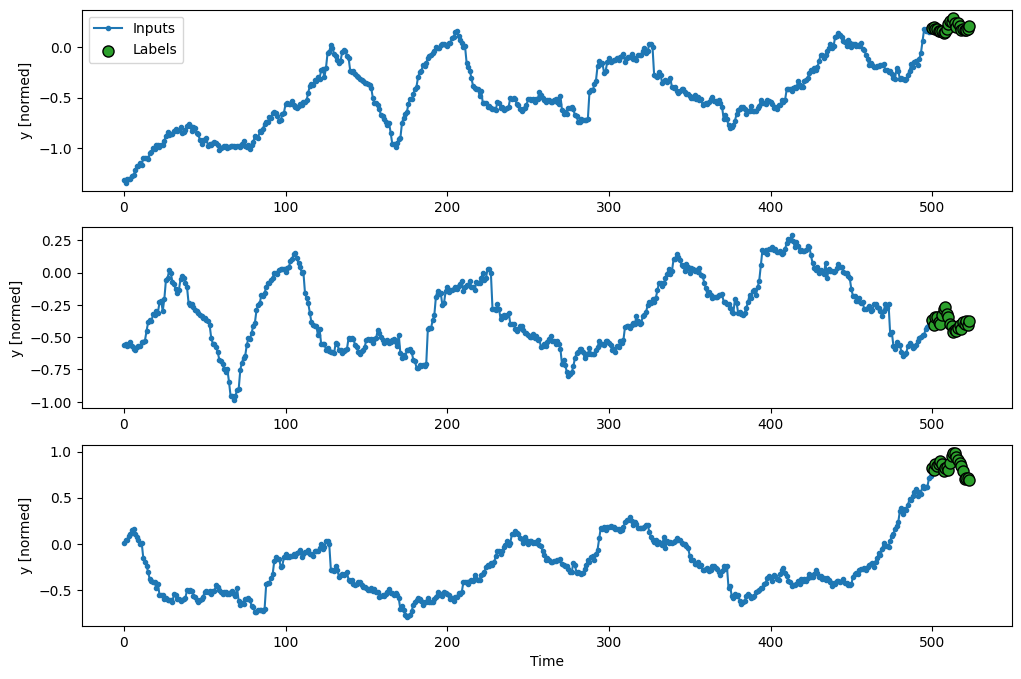

In [ ]:
OUT_STEPS = 24
# Assuming you have already loaded and split your dataset into train_df, val_df, and test_df
window = WindowGenerator(input_width=500,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df,
                               label_columns='y')


example_window = tf.stack([np.array(train_df[:window.total_window_size]),
                           np.array(train_df[100:100+window.total_window_size]),
                           np.array(train_df[200:200+window.total_window_size])])

inputs, labels = window.split_window(example_window)

window.plot(example_input=inputs, example_labels=labels)


<h3> Dense

In [ ]:
import numpy as np


# Check for infinite values in validation set
for x, y in window.val.take(1):
    if tf.reduce_any(tf.math.is_inf(x)):
        print("Validation set contains infinite values")

    
# Check for infinite values in test set
for x, y in window.test.take(1):
    if tf.reduce_any(tf.math.is_inf(x)):
        print("Test set contains infinite values")


In [ ]:
import numpy as np

if np.any(np.isnan(train_df)) or np.any(np.isnan(val_df)) or np.any(np.isnan(test_df)):
    print("Output data contains NaN values")
    
if np.any(np.isinf(train_df)) or np.any(np.isinf(val_df)) or np.any(np.isinf(test_df)):
    print("Output data contains infinite values")


Epoch 1/5
67/67 [==============================] - 1s 8ms/step - loss: 0.3353 - mean_absolute_error: 0.3940 - val_loss: 0.2768 - val_mean_absolute_error: 0.3681
Epoch 2/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0646 - mean_absolute_error: 0.1766 - val_loss: 0.2447 - val_mean_absolute_error: 0.3470
Epoch 3/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0592 - mean_absolute_error: 0.1622 - val_loss: 0.2371 - val_mean_absolute_error: 0.3423
Epoch 4/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0565 - mean_absolute_error: 0.1539 - val_loss: 0.2378 - val_mean_absolute_error: 0.3410
Epoch 5/5
8/8 [==============================] - 0s 3ms/step - loss: 0.2393 - mean_absolute_error: 0.3411


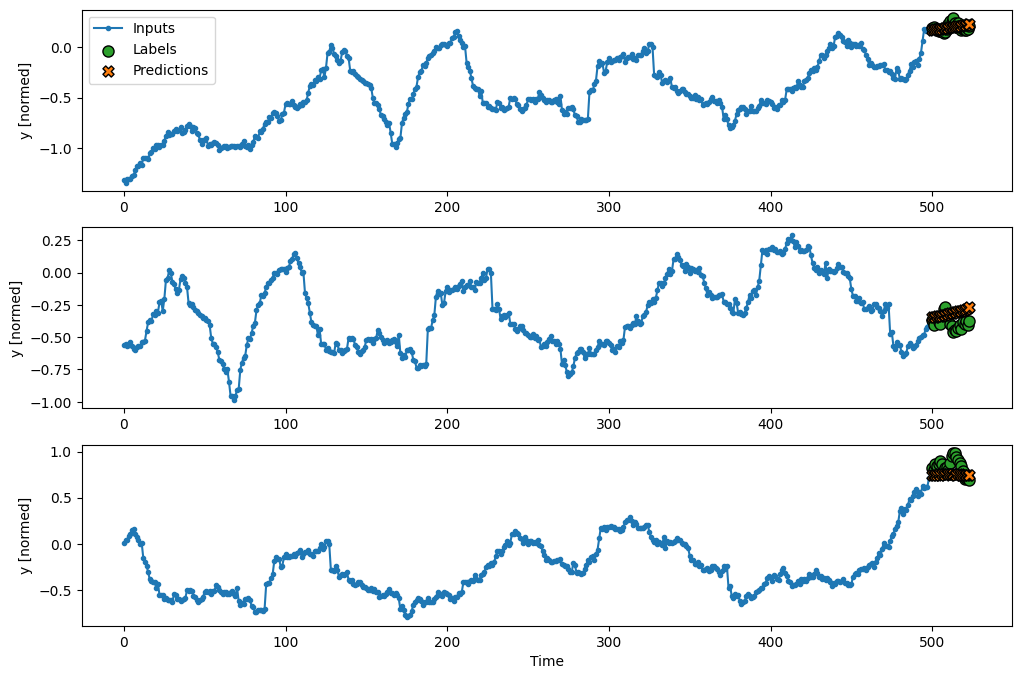

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

def compile_and_fit(model, window):
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=5,
                        validation_data=window.val)
    return history

history = compile_and_fit(multi_dense_model, window)

val_performance = {}
performance = {}
val_performance['Dense'] = multi_dense_model.evaluate(window.val)
performance['Dense'] = multi_dense_model.evaluate(window.test, verbose=0)
window.plot(multi_dense_model)

<h3> Conv Model

8/8 [==============================] - 0s 3ms/step - loss: 0.2743 - mean_absolute_error: 0.3709


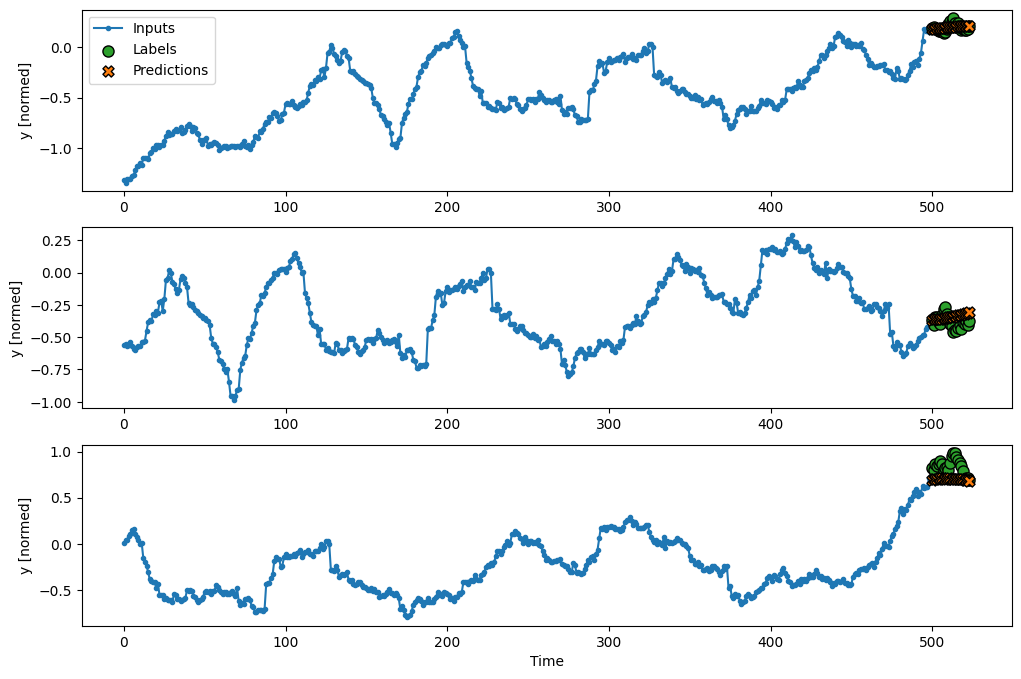

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=CONV_WIDTH),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, window)

from IPython.display import clear_output

clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(window.test, verbose=0)
window.plot(multi_conv_model)
